In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from prep_data import Dataset 
from torch.utils.data import DataLoader
from LSTM_Net import LSTM_Net 
import torch.nn as nn 
import torch 
import numpy as np
import math 
import random
import gc
import time 
from skimage.transform import resize
from util import * 
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os,sys


from torch.utils.tensorboard import SummaryWriter


### SEED for reproducability  

In [2]:
torch.backends.cudnn.deterministic = True
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)



In [3]:
## GPU 
os.environ["CUDA_VISIBLE_DEVICES"]= '1'


## Global variables 

In [4]:
# data paths and parameters
data_path = '../LSTM_Otway_submitted_v2/data'
base_path = f"{data_path}/base_otw.npy" 
mon_path = f"{data_path}/mon_otw.npy" 

parm = {
 'nt': 1250,
 'ng': 605,
 'ns': 121,
 'dt': 0.002,
 'dg': 0.004000000189989805,
 'ds': 1.0,
 'ot': 0.0,
 'og': 0.012000000104308128,
 'os': 0.0}


# Hyperparameters for training
batchsz = 64 
num_epochs = 300 
LR = 0.002
hsz = 50
hsz = 51
act = 'tanh'
n_layer=2
bias= False
dropout = 0.


# define the overburden window 
# start= 100 
# last = 650 

feature_length=41

# # define the overburden window 
start = 450
last =  650 

epoch=0

hyperpar = f"_lr{LR}_nlayer{n_layer}_act{act}_bias{bias}_batchsz{batchsz}_time_start{start}_end{last}"

net_path = "./Network/"

# -----------------------------------------------#
# RSF PATH 
# path = '/home/alaliaa/Time_lapse_ML/ML_Models2/data/'
# base = path + 'Base_data.rsf'
# mon = path + 'MonNoisy_data.rsf'

In [5]:

base = np.load(base_path)
mon = np.load(mon_path)
 
ns,ng,nt = base.shape
print ('ns',ns,'ng',ng,'nt',nt)

# # Take only few shots 
# base = base[30:50,]
# mon = mon[30:50,]
# ns,ng,nt_ = base.shape

# Take only few shots 
# base = base[50:70:2,]
# mon = mon[50:70:2,]
# ns,ng,nt_ = base.shape


base = base.reshape((ns*ng,nt))
mon = mon.reshape((ns*ng,nt))

print('data shapeed to 2d',base.shape)


ns 120 ng 609 nt 1250
data shapeed to 2d (73080, 1250)


In [6]:

skip=3
base = base[::skip,]
mon = mon[::skip,]
print(f"data shape after slipping {skip} traces: {base.shape}")

data shape after slipping 3 traces: (24360, 1250)


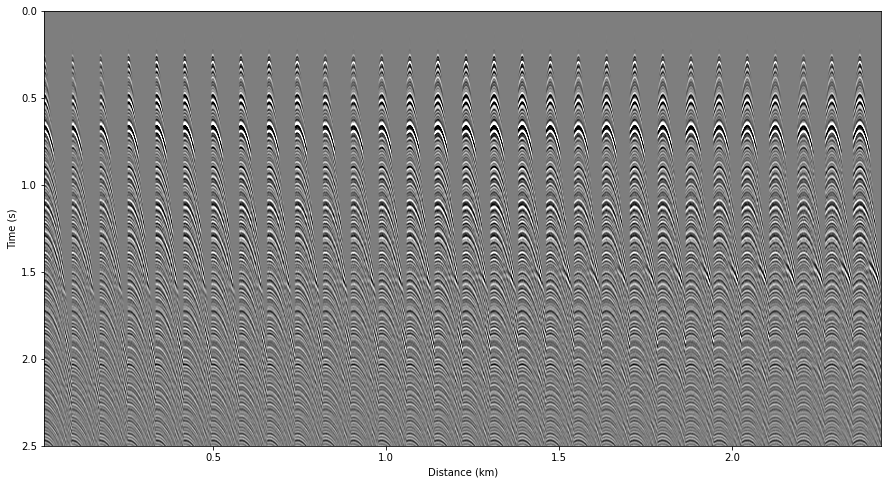

In [7]:
def Plot_shot(data,par):
    vmin, vmax = np.percentile(data, [2,98])
    plt.figure(figsize=(15,8))
    plt.imshow(data[0*ng:10*ng,:].T, aspect='auto',
           vmin=vmin, vmax=vmax,cmap='gray',extent=[par['og'],par['dg']*par['ng']+par['og'],
                                                    par['nt']*par['dt']+par['ot'],par['ot']])
    plt.ylabel('Time (s)')
    plt.xlabel('Distance (km)')

# This plot 2D concatenated shots 
Plot_shot(base-mon,parm)

In [8]:
''' Pre Processing the data for trainign 
    - specify the overburden time window 
    - split the data into training and testing 
    - scale the data 

'''

def scale_data(data=None):
    print('shape of data that will be scaled', data.shape)
    assert len(data.shape)==2
    ng,nt = data.shape  
    
    data = data.T
    scaler= MinMaxScaler(feature_range=(-1,1))
    # scaler= StandardScaler()
    scaler.fit(data)
    scaled_data = scaler.transform(data)
    scaled_data = scaled_data.T 


    return scaled_data,scaler
         




 
base = base[:,start:last]
base = base[~np.all(base==0 , axis=1)] # this exclude the zero traces 
mon = mon[:,start:last]   
mon = mon[~np.all(mon==0 , axis=1)] # this exclude the zero traces 


# split data 
test_size = 0.2
base_train,base_test,mon_train,mon_test  =  train_test_split(base,mon,test_size=test_size,shuffle=True)
# base_train = base[:,:150]
# mon_train = mon[:,:150]
# base_test = base[:,150:]
# mon_test = mon[:,150:]



Ntrain = base_train.shape[0]
Ntest = base_test.shape[0]



# scaling
base_train, base_train_scaler = scale_data(base_train) 
mon_train , mon_train_scaler  = scale_data(mon_train) 
base_test , base_test_scaler  = scale_data(base_test) 
mon_test  , mon_test_scaler   = scale_data(mon_test) 


# move to torch 
base_train = torch.from_numpy(base_train).double()
mon_train  = torch.from_numpy(mon_train).double()
base_test  = torch.from_numpy(base_test).double()
mon_test   = torch.from_numpy(mon_test).double()





shape of data that will be scaled (17044, 200)
shape of data that will be scaled (17044, 200)
shape of data that will be scaled (4261, 200)
shape of data that will be scaled (4261, 200)


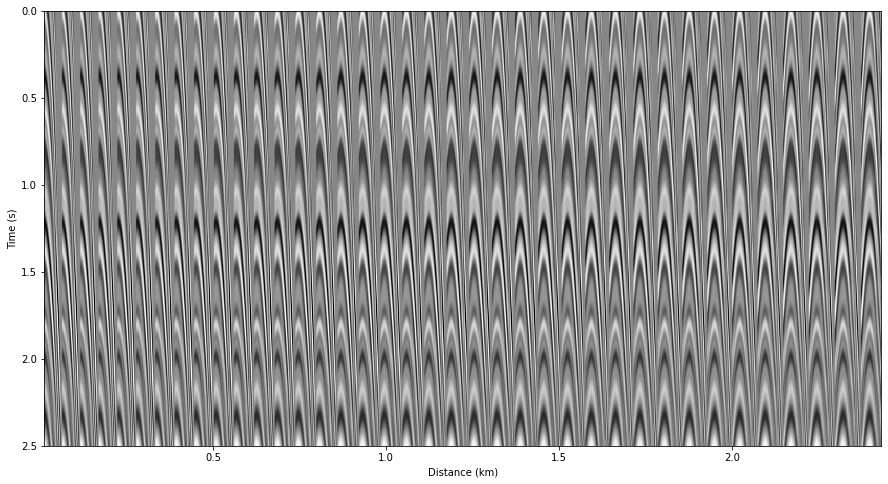

In [9]:
def Plot_shot(data,par):
    vmin, vmax = np.percentile(data, [2,98])
    plt.figure(figsize=(15,8))
    plt.imshow(data[0*ng:10*ng,:].T, aspect='auto',
           vmin=vmin, vmax=vmax,cmap='gray',extent=[par['og'],par['dg']*par['ng']+par['og'],
                                                    par['nt']*par['dt']+par['ot'],par['ot']])
    plt.ylabel('Time (s)')
    plt.xlabel('Distance (km)')

# This plot 2D concatenated shots 
Plot_shot(base,parm)

# Prepare input window

In [10]:
def window (x,dimension=-1,size=11,step=1):
    ''' x has to be pytorch tensor'''
    return x.unfold(dimension,size,step)


print(base_train.shape)
base_train_win =window(base_train,size=feature_length,step=1)
mon_train_win =window(mon_train,size=feature_length,step=1)[:,:,feature_length//2]
mon_train_win = mon_train_win.view(mon_train_win.shape[0],mon_train_win.shape[1],-1)

base_test_win =window(base_test,size=feature_length,step=1)
mon_test_win =window(mon_test,size=feature_length,step=1)[:,:,feature_length//2]
mon_test_win = mon_test_win.view(mon_test_win.shape[0],mon_test_win.shape[1],-1)


print(base_train_win.shape),print(mon_train_win.shape)
print(base_test_win.shape),print(mon_test_win.shape)



torch.Size([17044, 200])
torch.Size([17044, 160, 41])
torch.Size([17044, 160, 1])
torch.Size([4261, 160, 41])
torch.Size([4261, 160, 1])


(None, None)

In [11]:
# Prepare the data to be trained 
training_data = Dataset(base_train_win,mon_train_win)
testing_data = Dataset(base_test_win,mon_test_win)

train_loader= DataLoader (dataset=training_data,batch_size=batchsz,shuffle=True)
test_loader= DataLoader(dataset=testing_data,batch_size=batchsz,shuffle=True)

# to see the batch that are loaded 
# next(iter(data_loader)) ?



In [12]:
# Set up network and 

model = LSTM_Net(input_size=base_train_win.shape[-1], hidden_layer_size=hsz, 
                output_size=mon_train_win.shape[-1],
                batch_sz=batchsz,num_lstm_layer=n_layer,activation=act,dropout=dropout,bias=bias)
# model = LSTM_Net2(1,hsz,1,batchsz)
model = model.double()
model.cuda()
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(),lr=LR)
optimizer = torch.optim.Adam(model.parameters(),lr=LR,weight_decay=1e-7)
scheduler = ReduceLROnPlateau(optimizer,'min',verbose=True,patience=10,factor=0.1)
loss_arr=[]
loss_arr_test=[]
R2_train = []
R2_test = []
grad_norm = [] 

print(f"number of training samples {Ntrain} and validation sample {Ntest}")



number of training samples 17044 and validation sample 4261


In [13]:
# for i_test,loader_test in enumerate(test_loader,0):
#     inp, label = loader_test

#     plt.imshow(label[:,:,-1].numpy().T)
#     plt.axis('tight')
#     plt.colorbar()
#     plt.show()

In [14]:
# for i_test,loader_test in enumerate(train_loader,0):
#     inp, label = loader_test

#     plt.imshow(label[:,:,-1].numpy().T)
#     plt.axis('tight')
#     plt.colorbar()
#     plt.show()





In [ ]:
# Training loop 

start_time = time.time()
writer = SummaryWriter()

for epoch in range (num_epochs):
        epoch_loss = 0
        R2_train_running=0
        total_norm =0
        # loop over batches
        for i, loader, in enumerate(train_loader,0):
            optimizer.zero_grad()
            inputs, labels = loader
            inputs = inputs.cuda()
            labels = labels.cuda()
            if inputs.shape[0]!= batchsz: break
            model.h_init() # reset the hidden state for new series  
            inputs = inputs.view(inputs.shape[0],inputs.shape[1],-1)
            labels = labels.view(labels.shape[0],labels.shape[1],-1)
            y_pred = model(inputs)
            batch_loss = criterion(y_pred,labels)
            R2_train_running += r2_score(target=labels,prediction=y_pred)
            epoch_loss +=  batch_loss.item()
            batch_loss.backward()
            model.hidden_cell[0].detach_()
            model.hidden_cell[1].detach_()
            # Gradient clipping to avoid exploding problem 
            # torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=2,norm_type=2)

            optimizer.step()
            for p in model.parameters():
                param_norm = p.grad.detach().data.norm(2)
                total_norm += param_norm.item() ** 2
            total_norm += total_norm ** 0.5
            
        total_norm = total_norm/(i+1)    
        epoch_loss = epoch_loss / (i+1) # average by the number batch loops 
        R2_train_running = R2_train_running / (i+1) # average by the number batch loops 
  
        with   torch.no_grad():
            epoch_loss_test =0
            R2_test_running=0
            for i_test,loader_test in enumerate(test_loader,0):
                test_inp, test_label = loader_test
                if test_inp.shape[0]!= batchsz: break
                model.h_init()
                x_test = test_inp.cuda()
                y_test = test_label.cuda()  
                x_test = x_test.view(x_test.shape[0],x_test.shape[1],-1)
                y_test = y_test.view(y_test.shape[0],y_test.shape[1],-1)   
                test_pred = model(x_test)
                test_loss = criterion(test_pred,y_test)
                R2_test_running += r2_score(target = y_test,prediction = test_pred)
                epoch_loss_test += test_loss.item()
                # R2_test_running += R2
        epoch_loss_test = epoch_loss_test/ (i_test+1) # average by the number batch loops 
        R2_test_running = R2_test_running/  (i_test+1) # average by the number batch loops 
        scheduler.step(epoch_loss_test)  # this should reduce LR on plateau
        grad_norm.append(total_norm)
        loss_arr.append(epoch_loss)
        loss_arr_test.append(epoch_loss_test)
        R2_train.append(R2_train_running)
        R2_test.append(R2_test_running)
        print(f'epoch: {epoch+1:3}/{num_epochs:3}  Training_loss: {epoch_loss:.5e} Validation_loss: {epoch_loss_test:.5e} \n R2 training: {R2_train_running:.2} R2 test: {R2_test_running:.2}')

        if epoch%5 ==0 : torch.save(model.state_dict(),f'{net_path}LSTM_Otway_epc{epoch}{hyperpar}.pth')

        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Loss/test',epoch_loss_test, epoch)
        writer.add_scalar('grad_norm',total_norm, epoch)

        

end_time = time.time()  




epoch:   1/300  Training_loss: 1.39704e-02 Validation_loss: 4.82980e-03 
 R2 training: 0.93 R2 test: 0.96
epoch:   2/300  Training_loss: 4.21498e-03 Validation_loss: 4.24994e-03 
 R2 training: 0.98 R2 test: 0.97
epoch:   3/300  Training_loss: 3.83752e-03 Validation_loss: 3.99387e-03 
 R2 training: 0.98 R2 test: 0.97
epoch:   4/300  Training_loss: 3.63767e-03 Validation_loss: 3.86551e-03 
 R2 training: 0.98 R2 test: 0.97
epoch:   5/300  Training_loss: 3.53367e-03 Validation_loss: 3.74530e-03 
 R2 training: 0.98 R2 test: 0.97
epoch:   6/300  Training_loss: 3.44888e-03 Validation_loss: 3.64338e-03 
 R2 training: 0.98 R2 test: 0.97
epoch:   7/300  Training_loss: 3.36605e-03 Validation_loss: 3.60359e-03 
 R2 training: 0.98 R2 test: 0.97
epoch:   8/300  Training_loss: 3.28945e-03 Validation_loss: 3.55070e-03 
 R2 training: 0.98 R2 test: 0.97
epoch:   9/300  Training_loss: 3.24664e-03 Validation_loss: 3.46507e-03 
 R2 training: 0.98 R2 test: 0.97
epoch:  10/300  Training_loss: 3.17056e-03 Val

In [ ]:
print(f"Training time is  {(end_time-start_time)/60} min ")  

In [ ]:
# saving the model 
# old net in './Network/LSTM_Otway.pth'

torch.save(model.state_dict(),f'{net_path}LSTM_Otway_epc{epoch}{hyperpar}.pth')

loss_arr = np.array(loss_arr)
loss_arr_test = np.array(loss_arr_test) 

np.save(f'./loss_arr/Training_loss_Otway{hyperpar}',loss_arr)
np.save(f'./loss_arr/Testing_loss_Otway{hyperpar}',loss_arr_test)
# np.save('./loss_arr/Training_R2_Otway',np.array(R2_train))
# np.save('./loss_arr/Testing_R2_Otway',np.array(R2_test))

plot_history(loss_arr,loss_arr_test,f'Fig/loss_Otway{hyperpar}')


# plot_r2(R2_train,R2_test,'Fig/R2_Otway')


In [ ]:
def plot_history(trainingloss,testingloss,netname):

    Epc = np.arange(1,trainingloss.shape[0]+1)
    fig, ax = plt.subplots(figsize=(8,4))

    ax.semilogy(trainingloss,color='b',label='Training')
    ax.semilogy(testingloss,color='r',label='Validation')

    ax.grid(which='both')
    ax.set_xlabel('Epochs', fontsize=16, fontweight='bold')
    ax.set_ylabel('Loss ',fontsize=16, fontweight='bold')

    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0e'))

    ax.tick_params(axis='both',which='minor',labelsize=16)
    plt.xticks(fontsize=16,fontweight='semibold')
    plt.yticks(fontsize=16,fontweight='semibold')
    ax.legend(prop={'size': 16, 'weight':'bold'})

    name=netname+'.png'
    fig.savefig(name, bbox_inches='tight')


In [ ]:
# # saving the model 
# # old net in './Network/LSTM_Otway.pth'

# torch.save(model.state_dict(),f'{net_path}LSTM_Otway_epc{epoch}{hyperpar}.pth')

# loss_arr = np.array(loss_arr)
# loss_arr_test = np.array(loss_arr_test) 

# np.save(f'./loss_arr/Training_loss_Otway{hyperpar}',loss_arr)
# np.save(f'./loss_arr/Testing_loss_Otway{hyperpar}',loss_arr_test)
# # np.save('./loss_arr/Training_R2_Otway',np.array(R2_train))
# # np.save('./loss_arr/Testing_R2_Otway',np.array(R2_test))

# plot_history(loss_arr,loss_arr_test,'Fig/loss_Otway{hyperpar}')


# plot_r2(R2_train,R2_test,'Fig/R2_Otway')
